In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Lung12_generate.ipynb	   Lung5_Rep2_generate.ipynb  Lung9_Rep1_generate.ipynb
Lung13_generate.ipynb	   Lung5_Rep3_generate.ipynb  Lung9_Rep2_generate.ipynb
Lung5_Rep1_generate.ipynb  Lung6_generate.ipynb       notes.txt
/mnt/ufs18/home-144/dingjia5/projects/CosMx_lung/benchmark_generation_scripts


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/Lung5_Rep3_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-8324.222222,1431.113869,1898.000000,3292.224980,6,IGHA1,Nuclear
1,1,0,-6053.702222,796.508889,4168.520000,2657.620000,6,IL7R,0
2,1,0,-10161.347222,401.938789,60.875000,2263.049900,6,HLA-DRA,Membrane
3,1,0,-6384.097222,165.738989,3838.125000,2026.850100,6,IFNGR2,0
4,1,0,-7985.822222,-647.001211,2236.400000,1214.109900,6,IGHA1,0
...,...,...,...,...,...,...,...,...,...
31481627,30,4637,16294.266764,16400.009250,4627.600098,11.120361,2,SEC61G,Cytoplasm
31481628,30,4637,16284.987956,16402.302951,4618.321289,13.414062,3,TYROBP,Cytoplasm
31481629,30,4637,16280.010905,16403.877903,4613.344238,14.989014,5,S100A4,Cytoplasm
31481630,30,4637,16280.304850,16400.519504,4613.638184,11.630615,5,GLUL,Nuclear


In [6]:
gene_spatial.loc[gene_spatial['fov']==1]

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-8324.222222,1431.113869,1898.000000,3292.224980,6,IGHA1,Nuclear
1,1,0,-6053.702222,796.508889,4168.520000,2657.620000,6,IL7R,0
2,1,0,-10161.347222,401.938789,60.875000,2263.049900,6,HLA-DRA,Membrane
3,1,0,-6384.097222,165.738989,3838.125000,2026.850100,6,IFNGR2,0
4,1,0,-7985.822222,-647.001211,2236.400000,1214.109900,6,IGHA1,0
...,...,...,...,...,...,...,...,...,...
492289,1,2436,-9402.776727,-1848.274441,819.445496,12.836670,5,TAGLN,Cytoplasm
492290,1,2436,-9396.393609,-1849.253689,825.828613,11.857422,5,IL1RAP,Nuclear
492291,1,2437,-5203.922418,-1842.061062,5018.299805,19.050049,3,CX3CL1,Cytoplasm
492292,1,2437,-5217.421929,-1839.891140,5004.800293,21.219971,4,CD14,Cytoplasm


In [7]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==1) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
79779,1,1,-10165.472226,1758.167463,56.749996,3619.278574,5,CXCR6,Cytoplasm
79780,1,1,-10172.697225,1761.163889,49.524998,3622.275000,5,MALAT1,Cytoplasm


In [8]:
gene_expression = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/Lung5_Rep3_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,17,24,33,11,24,43,12,25,...,9,12,14,23,13,12,27,13,14,14
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100289,30,4633,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100290,30,4634,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100291,30,4635,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100292,30,4636,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
cell_boundary = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/Lung5_Rep3_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1463,2.31,48,3634,-10174.222222,1772.888889,67,29,3615,11455,2317,12466,454,1200,102,680,5298,22792
1,1,2,1366,2.88,1232,3636,-8990.222222,1774.888889,72,25,4104,7767,1746,10388,720,2237,137,856,11451,43504
2,1,3,2666,1.40,1489,3623,-8733.222222,1761.888889,70,50,1770,3611,2213,14635,221,1141,63,742,9419,40722
3,1,4,1507,1.76,1661,3631,-8561.222222,1769.888889,60,34,6298,11618,13304,35095,343,1041,100,724,5754,16662
4,1,5,2569,1.13,2054,3621,-8168.222222,1759.888889,61,54,3913,9346,1005,5156,282,1003,52,708,6,780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100259,30,4633,767,2.48,4800,13,16466.666667,16401.888889,57,23,888,1513,127,327,542,952,0,0,12326,21624
100260,30,4634,538,1.90,4468,12,16134.666667,16400.888889,40,21,1012,2278,325,841,328,574,0,0,14124,27824
100261,30,4635,1012,2.20,4563,14,16229.666667,16402.888889,55,25,1184,3320,189,558,468,1119,0,0,7650,19523
100262,30,4636,1258,3.38,5264,12,16930.666667,16400.888889,71,21,977,1737,192,411,413,1276,0,0,3870,11285


In [10]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==1)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1463,2.31,48,3634,-10174.222222,1772.888889,67,29,3615,11455,2317,12466,454,1200,102,680,5298,22792
1,1,2,1366,2.88,1232,3636,-8990.222222,1774.888889,72,25,4104,7767,1746,10388,720,2237,137,856,11451,43504
2,1,3,2666,1.40,1489,3623,-8733.222222,1761.888889,70,50,1770,3611,2213,14635,221,1141,63,742,9419,40722
3,1,4,1507,1.76,1661,3631,-8561.222222,1769.888889,60,34,6298,11618,13304,35095,343,1041,100,724,5754,16662
4,1,5,2569,1.13,2054,3621,-8168.222222,1759.888889,61,54,3913,9346,1005,5156,282,1003,52,708,6,780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,1,2433,1087,1.26,626,52,-9596.222222,-1809.111111,48,38,4627,10501,437,15128,234,1132,0,0,4411,13671
2433,1,2434,1266,0.85,4777,42,-5445.222222,-1819.111111,40,47,689,1508,6728,31378,184,459,0,0,5097,14908
2434,1,2435,4504,1.31,4216,34,-6006.222222,-1827.111111,85,65,2166,6630,17174,65147,278,1556,0,0,4731,15272
2435,1,2436,1741,1.64,835,19,-9387.222222,-1842.111111,59,36,4128,9695,559,3597,356,10170,0,0,8813,25761


In [11]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [12]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

48.0

In [13]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3634.0

In [14]:
fov_position = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/Lung5_Rep3_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,1,-10222.222222,-1861.111111
1,2,-4750.000000,-1861.111111
2,3,722.222222,-1861.111111
3,4,6194.444444,-1861.111111
4,5,11666.666667,-1861.111111
5,6,-10222.222222,1788.888889
6,7,-4750.000000,1788.888889
7,8,722.222222,1788.888889
8,9,6194.444444,1788.888889
9,10,11666.666667,1788.888889


# Benchmark Generation

In [28]:
"""
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [29]:
"""
CosMx: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [30]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [31]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

In [32]:
# fov_ids_lst = cell_boundary['fov'].unique()
# fov_ids_lst

In [33]:
# cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[0])]
# cell_boundary_fov_1

In [34]:
# new_col_val = cell_boundary_fov_1.shape[0]* [0]
# cell_boundary_fov_1.insert(loc=0, column='spot_id', value=new_col_val)

In [35]:
# print(cell_boundary_fov_1.shape[0])
# cell_boundary_fov_1


In [36]:
"""
1094.4 pixel
912 pixel

(0-1094.4, 0-912)
"""

'\n1094.4 pixel\n912 pixel\n\n(0-1094.4, 0-912)\n'

In [37]:
# def get_fov_mapping(cell_boundary_fov_11):
#     new_col_val = cell_boundary_fov_11.shape[0]* [0]
#     cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)
    
#     for i in range(cell_boundary_fov_11.shape[0]):
#         one_row_sample = cell_boundary_fov_11.iloc[i]
#         if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 1
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 2
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 3
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 4

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 5
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 6
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 7
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 8

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 9
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 10
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 11
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 12

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 13
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 14
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 15
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 16

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 17
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 18
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 19
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 20

#         else:
#             print("Wrong CenterX_local_px")
#     return cell_boundary_fov_11
    


In [38]:
# # cell_boundary, 82843 rows × 20 columns
# # fov_ids_lst: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# frames = []
# fov_ids_lst = cell_boundary['fov'].unique()
# for fov_id in fov_ids_lst:
#     fov_id = 1
#     print("fov_id:", fov_id)
#     cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
#     print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
#     cell_boundary_fov_with_spot_id = get_fov_mapping(cell_boundary_fov)
#     print("cell_boundary_fov_with_spot_id:", cell_boundary_fov_with_spot_id.shape)
# #     print(cell_boundary_fov_with_spot_id)
#     frames.append(cell_boundary_fov_with_spot_id)
#     break
# # result = pd.concat(frames)
# cell_boundary_fov_with_spot_id


In [39]:
# data_result = data_result.append({'spot_id' : 2, 'fov' : 1, 'cell_ID' : 1}, ignore_index = True)
# data_result

## 1. spot_fov_cellId_mapping.csv

In [15]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [16]:
data_final_result = pd.DataFrame(columns = ['spot_id', 'fov', 'cell_ID'])
data_final_result

,spot_id,fov,cell_ID


In [17]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1463,2.31,48,3634,-10174.222222,1772.888889,67,29,3615,11455,2317,12466,454,1200,102,680,5298,22792
1,1,2,1366,2.88,1232,3636,-8990.222222,1774.888889,72,25,4104,7767,1746,10388,720,2237,137,856,11451,43504
2,1,3,2666,1.40,1489,3623,-8733.222222,1761.888889,70,50,1770,3611,2213,14635,221,1141,63,742,9419,40722
3,1,4,1507,1.76,1661,3631,-8561.222222,1769.888889,60,34,6298,11618,13304,35095,343,1041,100,724,5754,16662
4,1,5,2569,1.13,2054,3621,-8168.222222,1759.888889,61,54,3913,9346,1005,5156,282,1003,52,708,6,780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100259,30,4633,767,2.48,4800,13,16466.666667,16401.888889,57,23,888,1513,127,327,542,952,0,0,12326,21624
100260,30,4634,538,1.90,4468,12,16134.666667,16400.888889,40,21,1012,2278,325,841,328,574,0,0,14124,27824
100261,30,4635,1012,2.20,4563,14,16229.666667,16402.888889,55,25,1184,3320,189,558,468,1119,0,0,7650,19523
100262,30,4636,1258,3.38,5264,12,16930.666667,16400.888889,71,21,977,1737,192,411,413,1276,0,0,3870,11285


In [18]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [19]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

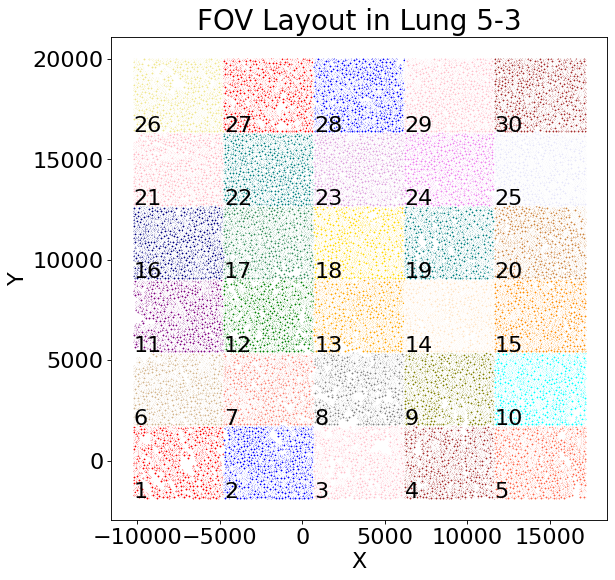

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Lung 5-3",fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/Lung5-3.png", format="png", bbox_inches="tight")
plt.show()


In [20]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
fov_id: 1
cell_boundary_fov_without_spot_id: (2437, 20)
fov_id: 2
cell_boundary_fov_without_spot_id: (3456, 20)
fov_id: 3
cell_boundary_fov_without_spot_id: (2598, 20)
fov_id: 4
cell_boundary_fov_without_spot_id: (3471, 20)
fov_id: 5
cell_boundary_fov_without_spot_id: (3185, 20)
fov_id: 6
cell_boundary_fov_without_spot_id: (5064, 20)
fov_id: 7
cell_boundary_fov_without_spot_id: (3687, 20)
fov_id: 8
cell_boundary_fov_without_spot_id: (2931, 20)
fov_id: 9
cell_boundary_fov_without_spot_id: (3218, 20)
fov_id: 10
cell_boundary_fov_without_spot_id: (3105, 20)
fov_id: 11
cell_boundary_fov_without_spot_id: (4077, 20)
fov_id: 12
cell_boundary_fov_without_spot_id: (3334, 20)
fov_id: 13
cell_boundary_fov_without_spot_id: (2956, 20)
fov_id: 14
cell_boundary_fov_without_spot_id: (2746, 20)
fov_id: 15
cell_boundary_fov_without_spot_id: (2643, 20)
fov_id: 16
cell_boundary_fov_without_spot_id: (4

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,8.0,1.0,2.0
2,8.0,1.0,3.0
3,8.0,1.0,4.0
4,8.0,1.0,5.0
...,...,...,...
100259,17.0,30.0,4633.0
100260,17.0,30.0,4634.0
100261,17.0,30.0,4635.0
100262,17.0,30.0,4636.0


In [21]:
data_final_result

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,8.0,1.0,2.0
2,8.0,1.0,3.0
3,8.0,1.0,4.0
4,8.0,1.0,5.0
...,...,...,...
100259,17.0,30.0,4633.0
100260,17.0,30.0,4634.0
100261,17.0,30.0,4635.0
100262,17.0,30.0,4636.0


In [23]:
data_final_result_sample = data_final_result[(data_final_result['fov']==1)]
data_final_result_sample

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,4.0,1.0,2.0
2,8.0,1.0,3.0
3,8.0,1.0,4.0
4,8.0,1.0,5.0
...,...,...,...
2299,13.0,1.0,2300.0
2300,13.0,1.0,2301.0
2301,1.0,1.0,2302.0
2302,5.0,1.0,2303.0


In [22]:
data_final_result.to_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')

In [23]:
data_final_result

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,8.0,1.0,2.0
2,8.0,1.0,3.0
3,8.0,1.0,4.0
4,8.0,1.0,5.0
...,...,...,...
100259,17.0,30.0,4633.0
100260,17.0,30.0,4634.0
100261,17.0,30.0,4635.0
100262,17.0,30.0,4636.0


## 2. spot_gene_expression.csv

In [24]:
data_final_result = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,spot_id,fov,cell_ID
0,0,4.0,1.0,1.0
1,1,8.0,1.0,2.0
2,2,8.0,1.0,3.0
3,3,8.0,1.0,4.0
4,4,8.0,1.0,5.0
...,...,...,...,...
100259,100259,17.0,30.0,4633.0
100260,100260,17.0,30.0,4634.0
100261,100261,17.0,30.0,4635.0
100262,100262,17.0,30.0,4636.0


In [25]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,17,24,33,11,24,43,12,25,...,9,12,14,23,13,12,27,13,14,14
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100289,30,4633,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100290,30,4634,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100291,30,4635,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100292,30,4636,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [27]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [28]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [29]:
fov_spot_cells_stats.to_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,119,125,194,137,112,128,129,173,100,...,82,137,110,78,118,144,136,99,89,141
1,2,161,191,115,99,332,168,120,129,217,...,143,125,289,225,116,136,215,194,162,179
2,3,158,150,157,109,168,69,134,124,106,...,143,132,114,119,82,110,186,156,127,124
3,4,170,148,109,176,177,134,238,231,160,...,211,286,133,150,131,112,158,211,170,167
4,5,182,170,198,202,161,148,250,195,131,...,151,166,153,153,123,137,112,105,169,175
5,6,219,250,269,96,219,298,265,220,218,...,208,240,260,259,290,366,217,236,362,267
6,7,220,310,216,137,318,280,122,155,166,...,169,208,153,165,176,153,122,154,129,148
7,8,187,89,199,208,119,165,132,171,118,...,118,144,155,135,149,102,136,113,232,167
8,9,218,185,132,143,144,180,160,179,232,...,164,138,177,144,184,138,153,114,153,100
9,10,150,151,145,129,174,142,128,112,205,...,156,120,180,196,152,169,97,127,151,197


In [30]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,spot_id,fov,cell_ID
95627,95627,4.0,30.0,1.0
95628,95628,4.0,30.0,2.0
95629,95629,4.0,30.0,3.0
95630,95630,4.0,30.0,4.0
95631,95631,4.0,30.0,5.0
...,...,...,...,...
100259,100259,17.0,30.0,4633.0
100260,100260,17.0,30.0,4634.0
100261,100261,17.0,30.0,4635.0
100262,100262,17.0,30.0,4636.0


In [31]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = list(gene_expression.columns)[2:]
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [32]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [33]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = list(fov_expression.columns)[2:]
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [34]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
  
    
  

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20
fov_id: 21
fov_id: 22
fov_id: 23
fov_id: 24
fov_id: 25
fov_id: 26
fov_id: 27
fov_id: 28
fov_id: 29
fov_id: 30


In [36]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,9,6,10,2,5,16,7,2,...,3,2,3,5,0,2,2,1,1,4
1,1,2,3,4,5,3,6,8,2,2,...,1,3,1,3,4,4,1,2,4,2
2,1,3,6,8,10,3,14,16,7,9,...,5,4,3,6,6,2,3,4,7,2
3,1,4,10,2,8,3,11,3,2,4,...,2,1,2,2,9,4,2,2,0,2
4,1,5,4,2,11,0,8,4,4,8,...,5,3,1,1,1,2,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30,16,2,40,39,4,12,59,17,9,...,4,5,9,8,3,12,17,2,3,10
596,30,17,1,4,33,3,8,24,17,4,...,5,2,8,6,3,5,2,4,4,3
597,30,18,1,14,21,3,6,19,7,2,...,2,5,2,6,2,3,8,4,2,3
598,30,19,2,15,15,5,10,4,9,3,...,2,2,2,6,4,8,6,6,4,3


In [38]:
spot_gene_expression.to_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/spot_gene_expression.csv')

## 3. Ground Truth

In [46]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [47]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_3 = CosMx_cell_type.iloc[sample_3_index_lst]
CosMx_cell_type_sample_3

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
203802,203803,c_3_1_3,1,2666,1.40,70,50,1770,3611,2213,...,980p,23,40,1.602060,0.008619,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11
203803,203804,c_3_1_5,1,2569,1.13,61,54,3913,9346,1005,...,980p,25,40,1.602060,0.008619,False,Lung5,macrophage,plasmablast-enriched stroma,0.00
203804,203805,c_3_1_6,1,2678,1.20,67,56,4786,11066,666,...,980p,59,102,2.008600,0.021980,False,Lung5,B-cell,stroma,0.00
203805,203806,c_3_1_7,1,3301,1.39,75,54,1747,7005,646,...,980p,33,49,1.690196,0.010559,False,Lung5,neutrophil,stroma,0.00
203806,203807,c_3_1_8,1,2087,1.02,52,51,3134,6292,581,...,980p,43,60,1.778151,0.012929,False,Lung5,endothelial,lymphoid structure,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301606,301607,c_3_30_4627,30,2565,2.35,87,37,167,1074,132,...,980p,56,90,1.954243,0.019394,False,Lung5,fibroblast,stroma,0.00
301607,301608,c_3_30_4628,30,1575,1.73,64,37,701,3242,224,...,980p,38,51,1.707570,0.010990,False,Lung5,fibroblast,lymphoid structure,0.00
301608,301609,c_3_30_4629,30,1998,2.03,73,36,270,1348,129,...,980p,77,115,2.060698,0.024781,False,Lung5,fibroblast,lymphoid structure,0.00
301609,301610,c_3_30_4632,30,563,1.04,25,24,794,1459,236,...,980p,15,20,1.301030,0.004310,False,Lung5,monocyte,lymphoid structure,0.00


In [48]:
CosMx_cell_type_sample_3.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_3

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,203803,c_3_1_3,1,2666,1.40,70,50,1770,3611,2213,...,980p,23,40,1.602060,0.008619,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11
1,203804,c_3_1_5,1,2569,1.13,61,54,3913,9346,1005,...,980p,25,40,1.602060,0.008619,False,Lung5,macrophage,plasmablast-enriched stroma,0.00
2,203805,c_3_1_6,1,2678,1.20,67,56,4786,11066,666,...,980p,59,102,2.008600,0.021980,False,Lung5,B-cell,stroma,0.00
3,203806,c_3_1_7,1,3301,1.39,75,54,1747,7005,646,...,980p,33,49,1.690196,0.010559,False,Lung5,neutrophil,stroma,0.00
4,203807,c_3_1_8,1,2087,1.02,52,51,3134,6292,581,...,980p,43,60,1.778151,0.012929,False,Lung5,endothelial,lymphoid structure,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97804,301607,c_3_30_4627,30,2565,2.35,87,37,167,1074,132,...,980p,56,90,1.954243,0.019394,False,Lung5,fibroblast,stroma,0.00
97805,301608,c_3_30_4628,30,1575,1.73,64,37,701,3242,224,...,980p,38,51,1.707570,0.010990,False,Lung5,fibroblast,lymphoid structure,0.00
97806,301609,c_3_30_4629,30,1998,2.03,73,36,270,1348,129,...,980p,77,115,2.060698,0.024781,False,Lung5,fibroblast,lymphoid structure,0.00
97807,301610,c_3_30_4632,30,563,1.04,25,24,794,1459,236,...,980p,15,20,1.301030,0.004310,False,Lung5,monocyte,lymphoid structure,0.00


In [49]:

for i in CosMx_cell_type_sample_3.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_3.at[i,'cell_ID']= int(CosMx_cell_type_sample_3.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_3


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,203803,3,1,2666,1.40,70,50,1770,3611,2213,...,980p,23,40,1.602060,0.008619,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11
1,203804,5,1,2569,1.13,61,54,3913,9346,1005,...,980p,25,40,1.602060,0.008619,False,Lung5,macrophage,plasmablast-enriched stroma,0.00
2,203805,6,1,2678,1.20,67,56,4786,11066,666,...,980p,59,102,2.008600,0.021980,False,Lung5,B-cell,stroma,0.00
3,203806,7,1,3301,1.39,75,54,1747,7005,646,...,980p,33,49,1.690196,0.010559,False,Lung5,neutrophil,stroma,0.00
4,203807,8,1,2087,1.02,52,51,3134,6292,581,...,980p,43,60,1.778151,0.012929,False,Lung5,endothelial,lymphoid structure,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97804,301607,4627,30,2565,2.35,87,37,167,1074,132,...,980p,56,90,1.954243,0.019394,False,Lung5,fibroblast,stroma,0.00
97805,301608,4628,30,1575,1.73,64,37,701,3242,224,...,980p,38,51,1.707570,0.010990,False,Lung5,fibroblast,lymphoid structure,0.00
97806,301609,4629,30,1998,2.03,73,36,270,1348,129,...,980p,77,115,2.060698,0.024781,False,Lung5,fibroblast,lymphoid structure,0.00
97807,301610,4632,30,563,1.04,25,24,794,1459,236,...,980p,15,20,1.301030,0.004310,False,Lung5,monocyte,lymphoid structure,0.00


In [50]:
sample_3_dic = {}
for key in CosMx_cell_type_sample_3["cell_type"].tolist():
    if key not in sample_3_dic:
        sample_3_dic[key] = 1
    else:
        sample_3_dic[key] = sample_3_dic[key] + 1

sample_3_dic


{'plasmablast': 7044,
 'macrophage': 7116,
 'B-cell': 8491,
 'neutrophil': 9634,
 'endothelial': 7755,
 'NK': 1614,
 'mast': 2404,
 'T CD4 naive': 8342,
 'Treg': 277,
 'pDC': 2659,
 'epithelial': 4036,
 'mDC': 4809,
 'fibroblast': 12290,
 'T CD8 naive': 2210,
 'T CD8 memory': 84,
 'tumor 5': 15893,
 'tumor 12': 616,
 'monocyte': 1926,
 'T CD4 memory': 563,
 'tumor 9': 18,
 'tumor 13': 18,
 'tumor 6': 10}

In [51]:
CosMx_cell_type_sample_3_fov_1 = CosMx_cell_type_sample_3[(CosMx_cell_type_sample_3['fov']==1)]
CosMx_cell_type_sample_3_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,203803,3,1,2666,1.40,70,50,1770,3611,2213,...,980p,23,40,1.602060,0.008619,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11
1,203804,5,1,2569,1.13,61,54,3913,9346,1005,...,980p,25,40,1.602060,0.008619,False,Lung5,macrophage,plasmablast-enriched stroma,0.00
2,203805,6,1,2678,1.20,67,56,4786,11066,666,...,980p,59,102,2.008600,0.021980,False,Lung5,B-cell,stroma,0.00
3,203806,7,1,3301,1.39,75,54,1747,7005,646,...,980p,33,49,1.690196,0.010559,False,Lung5,neutrophil,stroma,0.00
4,203807,8,1,2087,1.02,52,51,3134,6292,581,...,980p,43,60,1.778151,0.012929,False,Lung5,endothelial,lymphoid structure,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,206147,2431,1,3895,0.95,71,75,2894,7444,749,...,980p,92,152,2.181844,0.032754,False,Lung5,macrophage,stroma,0.17
2345,206148,2433,1,1087,1.26,48,38,4627,10501,437,...,980p,22,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.02
2346,206149,2434,1,1266,0.85,40,47,689,1508,6728,...,980p,22,24,1.380211,0.005172,False,Lung5,tumor 5,stroma,0.00
2347,206150,2435,1,4504,1.31,85,65,2166,6630,17174,...,980p,99,181,2.257679,0.039003,False,Lung5,epithelial,stroma,0.04


In [52]:
cell_type_lst = list(CosMx_cell_type_sample_3['cell_type'].unique())
print(len(cell_type_lst))
cell_type_lst

22


['plasmablast',
 'macrophage',
 'B-cell',
 'neutrophil',
 'endothelial',
 'NK',
 'mast',
 'T CD4 naive',
 'Treg',
 'pDC',
 'epithelial',
 'mDC',
 'fibroblast',
 'T CD8 naive',
 'T CD8 memory',
 'tumor 5',
 'tumor 12',
 'monocyte',
 'T CD4 memory',
 'tumor 9',
 'tumor 13',
 'tumor 6']

In [53]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + cell_type_lst
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,plasmablast,macrophage,B-cell,neutrophil,endothelial,NK,mast,T CD4 naive,...,fibroblast,T CD8 naive,T CD8 memory,tumor 5,tumor 12,monocyte,T CD4 memory,tumor 9,tumor 13,tumor 6


In [54]:
spot_celld_mapping = pd.read_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,spot_id,fov,cell_ID
0,0,4.0,1.0,1.0
1,1,8.0,1.0,2.0
2,2,8.0,1.0,3.0
3,3,8.0,1.0,4.0
4,4,8.0,1.0,5.0
...,...,...,...,...
100259,100259,17.0,30.0,4633.0
100260,100260,17.0,30.0,4634.0
100261,100261,17.0,30.0,4635.0
100262,100262,17.0,30.0,4636.0


In [56]:
CosMx_cell_type_sample_3


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,203803,3,1,2666,1.40,70,50,1770,3611,2213,...,980p,23,40,1.602060,0.008619,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11
1,203804,5,1,2569,1.13,61,54,3913,9346,1005,...,980p,25,40,1.602060,0.008619,False,Lung5,macrophage,plasmablast-enriched stroma,0.00
2,203805,6,1,2678,1.20,67,56,4786,11066,666,...,980p,59,102,2.008600,0.021980,False,Lung5,B-cell,stroma,0.00
3,203806,7,1,3301,1.39,75,54,1747,7005,646,...,980p,33,49,1.690196,0.010559,False,Lung5,neutrophil,stroma,0.00
4,203807,8,1,2087,1.02,52,51,3134,6292,581,...,980p,43,60,1.778151,0.012929,False,Lung5,endothelial,lymphoid structure,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97804,301607,4627,30,2565,2.35,87,37,167,1074,132,...,980p,56,90,1.954243,0.019394,False,Lung5,fibroblast,stroma,0.00
97805,301608,4628,30,1575,1.73,64,37,701,3242,224,...,980p,38,51,1.707570,0.010990,False,Lung5,fibroblast,lymphoid structure,0.00
97806,301609,4629,30,1998,2.03,73,36,270,1348,129,...,980p,77,115,2.060698,0.024781,False,Lung5,fibroblast,lymphoid structure,0.00
97807,301610,4632,30,563,1.04,25,24,794,1459,236,...,980p,15,20,1.301030,0.004310,False,Lung5,monocyte,lymphoid structure,0.00


In [57]:
cell_id_lst = CosMx_cell_type_sample_3["cell_ID"].tolist()
len(cell_id_lst)

97809

In [58]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [59]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
fov:       Unnamed: 0  spot_id  fov  cell_ID
0              0      4.0  1.0      1.0
1              1      8.0  1.0      2.0
2              2      8.0  1.0      3.0
3              3      8.0  1.0      4.0
4              4      8.0  1.0      5.0
...          ...      ...  ...      ...
2432        2432      1.0  1.0   2433.0
2433        2433     17.0  1.0   2434.0
2434        2434     13.0  1.0   2435.0
2435        2435      1.0  1.0   2436.0
2436        2436     17.0  1.0   2437.0

[2437 rows x 4 columns]
spot:       Unnamed: 0  spot_id  fov  cell_ID
1464        1464      1.0  1.0   1465.0
1474        1474      1.0  1.0   1475.0
1477        1477      1.0  1.0   1478.0
1479        1479      1.0  1.0   1480.0
1480        1480      1.0  1.0   1481.0
...          ...      ...  ...      ...
2386        2386      1.0  1.0   2387.0
2389        2389      1.0  1.0   2390.0
2

In [61]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = list(spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_3[(CosMx_cell_type_sample_3['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [64]:
ground_truth_table

,fov,spot_id,plasmablast,macrophage,B-cell,neutrophil,endothelial,NK,mast,T CD4 naive,...,fibroblast,T CD8 naive,T CD8 memory,tumor 5,tumor 12,monocyte,T CD4 memory,tumor 9,tumor 13,tumor 6
0,1.0,1.0,9.0,3.0,8.0,5.0,26.0,6.0,10.0,14.0,...,7.0,4.0,1.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0
1,1.0,2.0,29.0,14.0,10.0,15.0,14.0,4.0,3.0,15.0,...,1.0,4.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0
2,1.0,3.0,14.0,3.0,27.0,2.0,27.0,1.0,7.0,57.0,...,8.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,4.0,6.0,1.0,34.0,1.0,4.0,1.0,1.0,27.0,...,0.0,7.0,1.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,5.0,3.0,8.0,5.0,6.0,34.0,9.0,1.0,6.0,...,4.0,5.0,0.0,13.0,3.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,16.0,3.0,87.0,3.0,30.0,3.0,0.0,112.0,...,27.0,28.0,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0
596,30.0,17.0,1.0,3.0,83.0,1.0,19.0,1.0,1.0,52.0,...,49.0,22.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0
597,30.0,18.0,6.0,3.0,50.0,0.0,16.0,1.0,3.0,30.0,...,32.0,17.0,0.0,0.0,0.0,9.0,7.0,0.0,0.0,0.0
598,30.0,19.0,2.0,3.0,37.0,0.0,4.0,1.0,1.0,54.0,...,21.0,34.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0


In [65]:
ground_truth_table.shape

(600, 24)

In [66]:
lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
lung13_ground_truth

,Unnamed: 0,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0,1.0,1.0,49.0,24.0,48.0,5.0,4.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,2.0,35.0,18.0,59.0,5.0,3.0,0.0,0.0,...,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2,2,1.0,3.0,23.0,22.0,41.0,8.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,1.0,4.0,78.0,30.0,62.0,10.0,3.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,5.0,78.0,46.0,6.0,30.0,1.0,14.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,20.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,396,20.0,17.0,30.0,40.0,48.0,26.0,4.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
397,397,20.0,18.0,112.0,37.0,40.0,30.0,10.0,5.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0
398,398,20.0,19.0,26.0,33.0,30.0,13.0,6.0,10.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0


In [67]:
coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
coumn_names

['tumor 13',
 'fibroblast',
 'macrophage',
 'T CD4 memory',
 'T CD8 memory',
 'plasmablast',
 'B-cell',
 'mast',
 'Treg',
 'endothelial',
 'pDC',
 'T CD4 naive',
 'neutrophil',
 'T CD8 naive',
 'NK',
 'monocyte',
 'tumor 9',
 'tumor 12',
 'epithelial',
 'mDC',
 'tumor 5',
 'tumor 6']

In [68]:
first_n_column  = ground_truth_table.iloc[: , :2]
first_n_column

,fov,spot_id
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
595,30.0,16.0
596,30.0,17.0
597,30.0,18.0
598,30.0,19.0


In [69]:
cell_type_data = ground_truth_table.loc[:, coumn_names]
cell_type_data

,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0.0,7.0,3.0,2.0,1.0,9.0,8.0,10.0,2.0,26.0,...,5.0,4.0,6.0,0.0,0.0,2.0,8.0,1.0,2.0,0.0
1,0.0,1.0,14.0,1.0,0.0,29.0,10.0,3.0,1.0,14.0,...,15.0,4.0,4.0,2.0,0.0,1.0,6.0,0.0,0.0,0.0
2,0.0,8.0,3.0,1.0,1.0,14.0,27.0,7.0,2.0,27.0,...,2.0,5.0,1.0,1.0,0.0,0.0,21.0,4.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,6.0,34.0,1.0,0.0,4.0,...,1.0,7.0,1.0,0.0,0.0,1.0,35.0,3.0,8.0,0.0
4,0.0,4.0,8.0,2.0,0.0,3.0,5.0,1.0,0.0,34.0,...,6.0,5.0,9.0,0.0,0.0,3.0,5.0,1.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,27.0,3.0,4.0,0.0,16.0,87.0,0.0,0.0,30.0,...,3.0,28.0,3.0,6.0,0.0,0.0,1.0,19.0,0.0,0.0
596,0.0,49.0,3.0,6.0,0.0,1.0,83.0,1.0,3.0,19.0,...,1.0,22.0,1.0,7.0,0.0,0.0,0.0,24.0,0.0,0.0
597,0.0,32.0,3.0,7.0,0.0,6.0,50.0,3.0,0.0,16.0,...,0.0,17.0,1.0,9.0,0.0,0.0,0.0,25.0,0.0,0.0
598,0.0,21.0,3.0,0.0,0.0,2.0,37.0,1.0,2.0,4.0,...,0.0,34.0,1.0,7.0,0.0,0.0,0.0,27.0,0.0,0.0


In [70]:
lung1_ground_truth_table = pd.concat([first_n_column, cell_type_data], axis=1)
lung1_ground_truth_table

,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,1.0,1.0,0.0,7.0,3.0,2.0,1.0,9.0,8.0,10.0,...,5.0,4.0,6.0,0.0,0.0,2.0,8.0,1.0,2.0,0.0
1,1.0,2.0,0.0,1.0,14.0,1.0,0.0,29.0,10.0,3.0,...,15.0,4.0,4.0,2.0,0.0,1.0,6.0,0.0,0.0,0.0
2,1.0,3.0,0.0,8.0,3.0,1.0,1.0,14.0,27.0,7.0,...,2.0,5.0,1.0,1.0,0.0,0.0,21.0,4.0,0.0,0.0
3,1.0,4.0,0.0,0.0,1.0,1.0,1.0,6.0,34.0,1.0,...,1.0,7.0,1.0,0.0,0.0,1.0,35.0,3.0,8.0,0.0
4,1.0,5.0,0.0,4.0,8.0,2.0,0.0,3.0,5.0,1.0,...,6.0,5.0,9.0,0.0,0.0,3.0,5.0,1.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,27.0,3.0,4.0,0.0,16.0,87.0,0.0,...,3.0,28.0,3.0,6.0,0.0,0.0,1.0,19.0,0.0,0.0
596,30.0,17.0,0.0,49.0,3.0,6.0,0.0,1.0,83.0,1.0,...,1.0,22.0,1.0,7.0,0.0,0.0,0.0,24.0,0.0,0.0
597,30.0,18.0,0.0,32.0,3.0,7.0,0.0,6.0,50.0,3.0,...,0.0,17.0,1.0,9.0,0.0,0.0,0.0,25.0,0.0,0.0
598,30.0,19.0,0.0,21.0,3.0,0.0,0.0,2.0,37.0,1.0,...,0.0,34.0,1.0,7.0,0.0,0.0,0.0,27.0,0.0,0.0


In [71]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [72]:
lung1_ground_truth_table = swap_columns(lung1_ground_truth_table, 'tumor 13', 'tumor 5')
lung1_ground_truth_table

,fov,spot_id,tumor 5,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 13,tumor 6
0,1.0,1.0,2.0,7.0,3.0,2.0,1.0,9.0,8.0,10.0,...,5.0,4.0,6.0,0.0,0.0,2.0,8.0,1.0,0.0,0.0
1,1.0,2.0,0.0,1.0,14.0,1.0,0.0,29.0,10.0,3.0,...,15.0,4.0,4.0,2.0,0.0,1.0,6.0,0.0,0.0,0.0
2,1.0,3.0,0.0,8.0,3.0,1.0,1.0,14.0,27.0,7.0,...,2.0,5.0,1.0,1.0,0.0,0.0,21.0,4.0,0.0,0.0
3,1.0,4.0,8.0,0.0,1.0,1.0,1.0,6.0,34.0,1.0,...,1.0,7.0,1.0,0.0,0.0,1.0,35.0,3.0,0.0,0.0
4,1.0,5.0,13.0,4.0,8.0,2.0,0.0,3.0,5.0,1.0,...,6.0,5.0,9.0,0.0,0.0,3.0,5.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,27.0,3.0,4.0,0.0,16.0,87.0,0.0,...,3.0,28.0,3.0,6.0,0.0,0.0,1.0,19.0,0.0,0.0
596,30.0,17.0,0.0,49.0,3.0,6.0,0.0,1.0,83.0,1.0,...,1.0,22.0,1.0,7.0,0.0,0.0,0.0,24.0,0.0,0.0
597,30.0,18.0,0.0,32.0,3.0,7.0,0.0,6.0,50.0,3.0,...,0.0,17.0,1.0,9.0,0.0,0.0,0.0,25.0,0.0,0.0
598,30.0,19.0,0.0,21.0,3.0,0.0,0.0,2.0,37.0,1.0,...,0.0,34.0,1.0,7.0,0.0,0.0,0.0,27.0,0.0,0.0


In [73]:
del lung1_ground_truth_table['tumor 6']
del lung1_ground_truth_table['tumor 9']
del lung1_ground_truth_table['tumor 12']
del lung1_ground_truth_table['tumor 13']
lung1_ground_truth_table


,fov,spot_id,tumor 5,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,2.0,7.0,3.0,2.0,1.0,9.0,8.0,10.0,2.0,26.0,6.0,14.0,5.0,4.0,6.0,0.0,8.0,1.0
1,1.0,2.0,0.0,1.0,14.0,1.0,0.0,29.0,10.0,3.0,1.0,14.0,1.0,15.0,15.0,4.0,4.0,2.0,6.0,0.0
2,1.0,3.0,0.0,8.0,3.0,1.0,1.0,14.0,27.0,7.0,2.0,27.0,7.0,57.0,2.0,5.0,1.0,1.0,21.0,4.0
3,1.0,4.0,8.0,0.0,1.0,1.0,1.0,6.0,34.0,1.0,0.0,4.0,2.0,27.0,1.0,7.0,1.0,0.0,35.0,3.0
4,1.0,5.0,13.0,4.0,8.0,2.0,0.0,3.0,5.0,1.0,0.0,34.0,5.0,6.0,6.0,5.0,9.0,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,27.0,3.0,4.0,0.0,16.0,87.0,0.0,0.0,30.0,6.0,112.0,3.0,28.0,3.0,6.0,1.0,19.0
596,30.0,17.0,0.0,49.0,3.0,6.0,0.0,1.0,83.0,1.0,3.0,19.0,2.0,52.0,1.0,22.0,1.0,7.0,0.0,24.0
597,30.0,18.0,0.0,32.0,3.0,7.0,0.0,6.0,50.0,3.0,0.0,16.0,4.0,30.0,0.0,17.0,1.0,9.0,0.0,25.0
598,30.0,19.0,0.0,21.0,3.0,0.0,0.0,2.0,37.0,1.0,2.0,4.0,3.0,54.0,0.0,34.0,1.0,7.0,0.0,27.0


In [74]:

lung1_ground_truth_table.rename(columns = {'tumor 5':'tumor'}, inplace = True)

/mnt/ufs18/home-144/dingjia5/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [75]:
lung1_ground_truth_table

,fov,spot_id,tumor,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,2.0,7.0,3.0,2.0,1.0,9.0,8.0,10.0,2.0,26.0,6.0,14.0,5.0,4.0,6.0,0.0,8.0,1.0
1,1.0,2.0,0.0,1.0,14.0,1.0,0.0,29.0,10.0,3.0,1.0,14.0,1.0,15.0,15.0,4.0,4.0,2.0,6.0,0.0
2,1.0,3.0,0.0,8.0,3.0,1.0,1.0,14.0,27.0,7.0,2.0,27.0,7.0,57.0,2.0,5.0,1.0,1.0,21.0,4.0
3,1.0,4.0,8.0,0.0,1.0,1.0,1.0,6.0,34.0,1.0,0.0,4.0,2.0,27.0,1.0,7.0,1.0,0.0,35.0,3.0
4,1.0,5.0,13.0,4.0,8.0,2.0,0.0,3.0,5.0,1.0,0.0,34.0,5.0,6.0,6.0,5.0,9.0,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,27.0,3.0,4.0,0.0,16.0,87.0,0.0,0.0,30.0,6.0,112.0,3.0,28.0,3.0,6.0,1.0,19.0
596,30.0,17.0,0.0,49.0,3.0,6.0,0.0,1.0,83.0,1.0,3.0,19.0,2.0,52.0,1.0,22.0,1.0,7.0,0.0,24.0
597,30.0,18.0,0.0,32.0,3.0,7.0,0.0,6.0,50.0,3.0,0.0,16.0,4.0,30.0,0.0,17.0,1.0,9.0,0.0,25.0
598,30.0,19.0,0.0,21.0,3.0,0.0,0.0,2.0,37.0,1.0,2.0,4.0,3.0,54.0,0.0,34.0,1.0,7.0,0.0,27.0


In [76]:
lung1_ground_truth_table.to_csv('../Lung5_Rep3/Lung5_Rep3-Flat_files_and_images/new/ground_truth.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [40]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [41]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 9):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = 0
sample_cell_count_dic  

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}

In [42]:
sample_3_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 3:
        sample_3_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    if sample_id == 3:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [43]:
print(sample_cell_count_dic)
print(fov_lst)
print(len(sample_3_index_lst))

{1: 98002, 2: 105800, 3: 97809, 4: 89975, 5: 87606, 6: 139504, 7: 71304, 8: 81236}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
97809


In [44]:
len(sample_3_index_lst)

97809

## Comparison of 980 genes between our pseudo spot and GeoMx

In [28]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,4,17,24,16,12,12,3,8,...,7,8,8,14,8,5,11,11,13,5
1,1,2,7,22,25,12,13,13,9,7,...,8,6,6,11,6,15,22,4,9,2
2,1,3,5,7,28,11,11,8,6,2,...,7,3,14,5,3,9,7,8,4,6
3,1,4,3,26,24,8,12,7,9,12,...,10,10,9,14,5,9,9,10,6,7
4,1,5,15,33,41,31,17,14,11,8,...,15,12,9,25,12,17,17,10,13,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,20,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,20,17,2,10,14,11,8,0,3,3,...,5,2,7,3,4,3,5,0,5,0
397,20,18,7,17,26,13,13,10,10,9,...,14,8,11,12,11,6,14,5,10,11
398,20,19,6,9,10,3,1,1,4,4,...,7,2,0,0,1,2,3,1,1,0


In [29]:
spot_gene_expression["AATK"].mean()

7.905

In [30]:
cosmx_genes_name_lst = list(gene_expression.columns)[2:]
len(cosmx_genes_name_lst)

980

In [31]:
pseudo_spot_gene_dic = {}
for gene_name in cosmx_genes_name_lst:
    pseudo_spot_gene_dic[gene_name] = spot_gene_expression[gene_name].mean()
pseudo_spot_gene_dic  

{'AATK': 7.905,
 'ABL1': 20.0475,
 'ABL2': 28.455,
 'ACE': 14.555,
 'ACE2': 13.35,
 'ACKR1': 8.8275,
 'ACKR3': 11.0875,
 'ACKR4': 10.415,
 'ACTA2': 28.185,
 'ACTG2': 9.4325,
 'ACVR1': 17.2775,
 'ACVR1B': 21.62,
 'ACVR2A': 15.1575,
 'ACVRL1': 17.68,
 'ADGRA2': 14.5125,
 'ADGRA3': 18.0175,
 'ADGRB2': 6.8375,
 'ADGRB3': 9.65,
 'ADGRD1': 12.91,
 'ADGRE1': 6.9825,
 'ADGRE2': 13.48,
 'ADGRE5': 27.5325,
 'ADGRF1': 19.2,
 'ADGRF3': 10.1275,
 'ADGRF4': 7.4875,
 'ADGRF5': 18.135,
 'ADGRG1': 26.9175,
 'ADGRG2': 4.51,
 'ADGRG3': 10.875,
 'ADGRG5': 8.335,
 'ADGRG6': 11.09,
 'ADGRL1': 15.645,
 'ADGRL2': 10.3125,
 'ADGRL4': 9.68,
 'ADGRV1': 6.675,
 'ADIPOQ': 10.4675,
 'ADIRF': 22.1575,
 'ADM2': 17.905,
 'ADORA2A': 8.2525,
 'AGR2': 11.4975,
 'AHI1': 16.3625,
 'AHR': 27.6125,
 'AKT1': 48.795,
 'ALCAM': 51.2025,
 'ANGPT1': 11.0525,
 'ANGPT2': 7.6175,
 'ANGPT4': 6.6775,
 'ANGPTL1': 12.605,
 'ANXA1': 90.33,
 'ANXA2': 234.1125,
 'ANXA4': 49.2575,
 'APOA1': 7.835,
 'APOB': 7.33,
 'APOD': 50.7925,
 'APP': 10

In [32]:
len(pseudo_spot_gene_dic)

980

In [33]:
geomx_df = pd.read_csv('../../datasets/GeoMx/kidney/Kidney_Raw_TargetCountMatrix.txt', delimiter = "\t")
geomx_df

,TargetName,disease3_scan | 001 | PanCK,disease3_scan | 001 | neg,disease3_scan | 002 | PanCK,disease3_scan | 002 | neg,disease3_scan | 003 | PanCK,disease3_scan | 003 | neg,disease3_scan | 004 | PanCK,disease3_scan | 004 | neg,disease3_scan | 005 | PanCK,...,disease1B_scan | 015 | Geometric Segment,disease1B_scan | 016 | Geometric Segment,disease1B_scan | 017 | Geometric Segment,disease1B_scan | 018 | Geometric Segment,disease1B_scan | 019 | Geometric Segment,disease1B_scan | 020 | Geometric Segment,disease1B_scan | 021 | Geometric Segment,disease1B_scan | 022 | Geometric Segment,disease1B_scan | 023 | Geometric Segment,disease1B_scan | 024 | Geometric Segment
0,PADI2,15.0,35.0,36.0,41.0,9.0,37.0,42.0,37.0,14.0,...,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1,CYP24A1,23.0,32.0,23.0,41.0,3.0,30.0,34.0,32.0,17.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0
2,SUPT16H,35.0,66.0,46.0,61.0,20.0,39.0,79.0,66.0,43.0,...,1.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0
3,ZMIZ2,51.0,81.0,87.0,113.0,68.0,84.0,164.0,118.0,81.0,...,3.0,2.0,2.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0
4,SPAG9,48.0,65.0,46.0,91.0,25.0,58.0,95.0,81.0,45.0,...,8.0,10.0,7.0,3.0,1.0,7.0,5.0,4.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18499,TMPRSS4,42.0,38.0,45.0,61.0,30.0,31.0,110.0,49.0,82.0,...,1.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,1.0
18500,ATP6V0B,90.0,140.0,74.0,166.0,38.0,74.0,133.0,98.0,73.0,...,4.0,5.0,3.0,3.0,2.0,3.0,5.0,2.0,1.0,2.0
18501,DCHS1,23.0,59.0,38.0,69.0,23.0,38.0,64.0,55.0,28.0,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
18502,FAM166A,21.0,39.0,31.0,63.0,20.0,29.0,35.0,43.0,25.0,...,5.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0


In [34]:
# common gene names
geomx_gene_name_list = geomx_df['TargetName'].tolist()
print("length of geomx_gene_name_list:", len(geomx_gene_name_list))

common_gene_names_lst = []
for gene_name in cosmx_genes_name_lst:
    if gene_name in geomx_gene_name_list:
        common_gene_names_lst.append(gene_name)

print(len(common_gene_names_lst))


length of geomx_gene_name_list: 18504
932


In [35]:
# gene_expression = geomx_df[(geomx_df['TargetName'] == "CYP24A1")].values.tolist()[0][1:]
# sum(gene_expression) / len(gene_expression)

In [36]:
geomx_spot_gene_dic = {}
for gene_name in common_gene_names_lst:
    geomx_one_gene_expression = geomx_df[(geomx_df['TargetName'] == gene_name)].values.tolist()[0][1:]
    geomx_spot_gene_dic[gene_name] = sum(geomx_one_gene_expression) / len(geomx_one_gene_expression)
    
geomx_spot_gene_dic  

{'AATK': 8.753246753246753,
 'ABL1': 20.48051948051948,
 'ABL2': 15.207792207792208,
 'ACE': 13.70995670995671,
 'ACE2': 21.125541125541126,
 'ACKR1': 10.70995670995671,
 'ACKR3': 8.783549783549784,
 'ACKR4': 6.532467532467533,
 'ACTA2': 37.683982683982684,
 'ACTG2': 15.8008658008658,
 'ACVR1': 19.515151515151516,
 'ACVR1B': 30.02164502164502,
 'ACVR2A': 16.98701298701299,
 'ACVRL1': 24.19047619047619,
 'ADGRA2': 13.757575757575758,
 'ADGRA3': 19.506493506493506,
 'ADGRB2': 9.480519480519481,
 'ADGRB3': 13.181818181818182,
 'ADGRD1': 10.415584415584416,
 'ADGRE1': 10.497835497835498,
 'ADGRE2': 18.155844155844157,
 'ADGRE5': 23.735930735930737,
 'ADGRF1': 16.753246753246753,
 'ADGRF3': 11.333333333333334,
 'ADGRF4': 11.090909090909092,
 'ADGRF5': 65.12987012987013,
 'ADGRG1': 59.54112554112554,
 'ADGRG2': 11.554112554112555,
 'ADGRG3': 12.380952380952381,
 'ADGRG5': 12.034632034632034,
 'ADGRG6': 15.627705627705629,
 'ADGRL1': 16.943722943722943,
 'ADGRL2': 32.54112554112554,
 'ADGRL4'

In [37]:
len(geomx_spot_gene_dic)

932

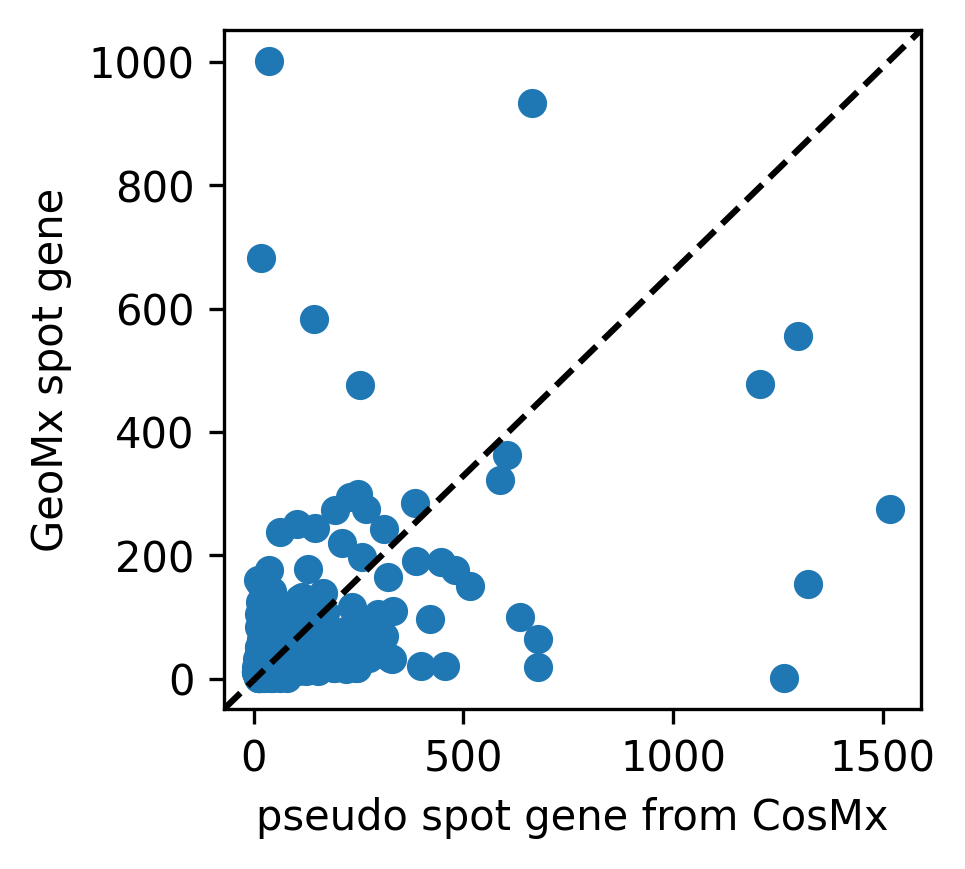

In [56]:
import matplotlib.pyplot as plt


x = []
y = []
for gene_name in common_gene_names_lst:
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

fig, ax = plt.subplots(1, 1,figsize=(3,3),dpi=300)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [39]:
len(x)

932

In [40]:
len(y)

932

corr: 0.4243927382321116


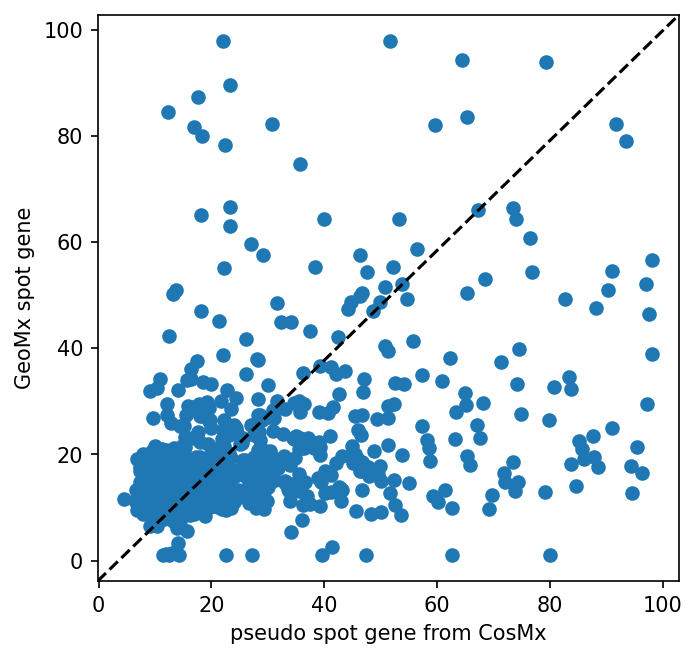

In [57]:


x = []
y = []
for gene_name in common_gene_names_lst:
    if pseudo_spot_gene_dic[gene_name] > 100:
        continue
    if geomx_spot_gene_dic[gene_name] > 100:
        continue
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [42]:
kidney_hk = pd.read_csv('../kidney_hk.csv')
kidney_hk

,Unnamed: 0,hks
0,1,PLA2R1
1,2,SPOCK2
2,3,MYL9
3,4,PTGDS
4,5,TGFBR2
5,6,ANXA2
6,7,DCN
7,8,FGF1
8,9,CD81
9,10,BGN


In [43]:
kidney_hk_lst = kidney_hk["hks"].tolist()

corr: 0.5320145396568767


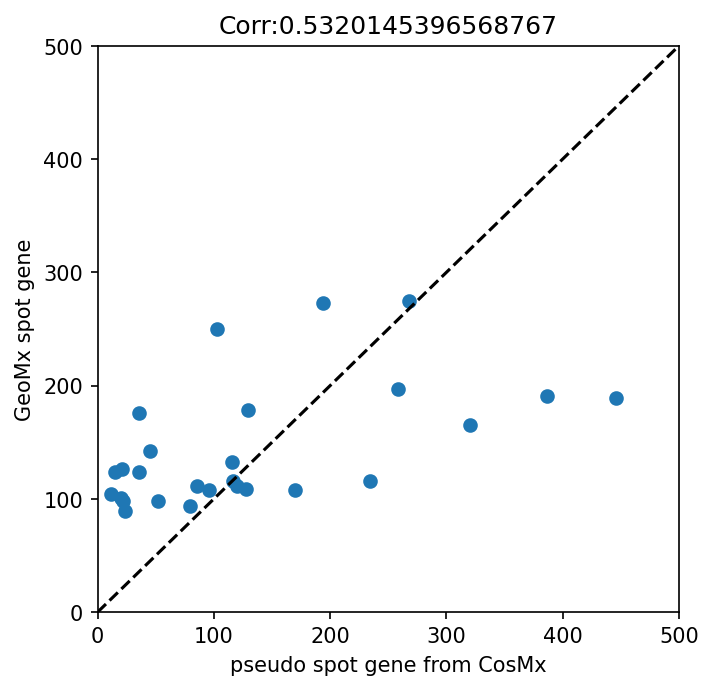

In [61]:
x = []
y = []

for gene_name in kidney_hk_lst:
    if pseudo_spot_gene_dic[gene_name] > 800:
        continue

    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")

plt.xlim(0,500)
plt.ylim(0,500)
plt.title('Corr:' + str(corr))

plt.scatter(x, y)
plt.show()